In [1]:
rootPath = "./"

In [2]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import math
from __future__ import print_function
from IPython.core.display import HTML
# This just lets the output of the following code samples
#  display inline on this page.%pylab inline
%pylab inline
from pylab import *
from sets import Set
from math import radians, cos, sin, asin, sqrt
import tarfile

# Set default figure size for this notebook
pylab.rcParams['figure.figsize'] = (8.0, 6.4)

stationsList=[]
cityLongLatMap = {}
maxProbMap = {}
p5ProbMap = {}
sumProbMap = {}
totalProbMap = {}
actualResultMap = {}
novTempSnowPredMap = {}

#tar = tarfile.open("ghcnd_all.tar.gz")

def loadTable(station):
    
    path = rootPath + "ghcnd_all/" + station + ".dly"
    
    #tar.extract("ghcnd_all/" + station + ".dly")

    colSpecs = [(0, 11), (11, 15), (15, 17), (17,21), 
                (21,26),(29,34),(37,42),(45,50),(53,58),(61,66),(69,74),(77,82),(85,90),(93,98),
                (101,106),(109,114),(117,122),(125,130),(133,138),(141,146),(149,154),(157,162),
                (165,170),(173,178),(181,186),(189,194),(197,202),(205,210),(213,218),(221,226),
                (229,234),(237,242),(245,250),(253,258),(261,266) ]
    datatable = pd.read_fwf(path, colspecs=colSpecs, header=None)
    datatable.columns = ["fname","year","month","element","1","2","3","4","5","6","7","8","9","10",
                         "11","12","13","14","15","16","17","18","19","20","21","22","23","24","25",
                         "26","27","28","29","30","31"]
    return datatable

def fwfColSpecGenerator():
    (x,y) = (21,26)
    s = ""
    for i in range(31):
        s = s + "("+str(x)+","+str(y)+")"+","
        x = x+8
        y = y+8
    return ss

def computeProb(city, station, stationFrame, startYear, endYear, month, day, isGetActual):
        
    snowNum,snowDen,snowdNum,snowdDen,totalNum,totalDen = 0,0,0,0,0,0
    
    df = stationFrame
    # 1 inch = 25 mm
    df1Den = df[(df['element'] == "SNOW") & (df['year'] > startYear) & (df['year'] <= endYear) & (df['month'] == month)]
    df2Den = df[(df['element'] == "SNWD") & (df['year'] > startYear) & (df['year'] <= endYear) & (df['month'] == month)]
    
#     df1 = df[(df['element'] == "SNOW") & (df['year'] > startYear) & (df['month'] == 12) & 
#              ((df['23'] >= 25) | (df['24'] >= 25) |(df['25'] >= 25) |(df['26'] >= 25) |(df['27'] >= 25))]
    df1 = df[(df['element'] == "SNOW") & (df['year'] > startYear) & (df['year'] <= endYear) & (df['month'] == month) & (df[day] >= 25)]
    
    if len(df1Den.index) > 5 and df1Den['year'].max() == endYear:
        snowNum = len(Set(df1['year']))
        snowDen = df1Den['year'].max() - df1Den['year'].min() + 1

    # display(HTML(df1[['year','25']].to_html()))
#     df2 = df[(df['element'] == "SNWD") & (df['year'] > startYear) & (df['month'] == 12) & 
#              ((df['23'] >= 25) | (df['24'] >= 25) |(df['25'] >= 25) |(df['26'] >= 25) |(df['27'] >= 25))]
    df2 = df[(df['element'] == "SNWD") & (df['year'] > startYear) & (df['year'] <= endYear) & (df['month'] == month) & (df[day] >= 25)]
    
    if len(df2Den.index) > 5 and df2Den['year'].max() == endYear:
        snowdNum = len(Set(df2['year']))
        snowdDen = df2Den['year'].max() - df2Den['year'].min() + 1

    resultProb = -1
    if snowDen > 0:
        snowprob = float(snowNum) / snowDen
        resultProb = max(resultProb, snowprob)
    if snowdDen > 0:
        snowdprob = float(snowdNum) / snowdDen
        resultProb = max(resultProb, snowdprob)
        
    if isGetActual:
        novtmpDf = df[(df['element'] == "TMIN") & (df['year'] == endYear+1) & (df['month'] == 11)]
        novTempSum = 0
        novTempCount = 0
        for ci, crow in novtmpDf.iterrows():
            for i in range(1,32):
                if crow[str(i)] != -9999:
                    novTempSum += (crow[str(i)] / 10.0)
                    novTempCount += 1.0
        
        novTempAvg = (novTempSum/novTempCount) if novTempCount > 0 else -9999
        
        adfSnwd = df[(df['element'] == "SNWD") & (df['year'] == endYear+1) & (df['month'] == month) & (df[day] >= 25)]
        adfSnow = df[(df['element'] == "SNOW") & (df['year'] == endYear+1) & (df['month'] == month) & (df[day] >= 25)]
        if (len(adfSnwd.index) == 1 and df2Den['year'].max() == endYear) or (len(adfSnow.index) == 1 and df1Den['year'].max() == endYear):
            return (resultProb, 1, novTempAvg)
        else:
            return (resultProb, 0, novTempAvg)
            
    
    return resultProb


    
#computeProbCityList()
def loadStationCoordinates():
    
    #datatable = pd.read_table(path, sep=',', header=None)
    #datatable.columns = ["Code","Lat","Lon","X","Y","StationName","A","B","C"]
    path = rootPath + "ghcnd-stations-us-1.csv"
    datatable = pd.read_table(path, sep=',', header=0)
    datatable.columns = ["Code","Lat","Lon"]
    return datatable



def loadCityCoordinates():
    path = rootPath + "capitals_coord.csv"
    datatable = pd.read_table(path, sep=',', header=None)
    datatable.columns = ["Country","City","Lat","Lon","Pop"]
    return datatable


def loadUSStateCapitalCoordinates():
    path = rootPath + "us_state_capitals_coord.csv"
    datatable = pd.read_table(path, sep=',', header=0)
    # Abbrev           State         Capital        Lat         Lon      Pop  Area
    return datatable


def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 

    # 6367 km is the radius of the Earth
    km = 6367 * c
    return km 

def findNearestStations():
    cityFrame = loadUSStateCapitalCoordinates()
    stationsFrame = loadStationCoordinates()
    resultFrame = DataFrame(columns=("city", "state", "station", "statlon", "statlat"))
    rowIndex = 0
    for oi, orow in cityFrame.iterrows():
        for ii, irow in stationsFrame.iterrows():
            distance = haversine(orow["Lon"], orow["Lat"], irow["Lon"], irow["Lat"])
            radiusSq = orow["Area"] / 3.14
            radius = sqrt(radiusSq)
            if distance <= radius + 20:
                print(orow["Capital"],radius,irow["Code"], distance)
                resultFrame.loc[rowIndex] = [orow["Capital"], orow["State"], irow["Code"], irow["Lon"], irow["Lat"]]
                rowIndex = rowIndex + 1
    return resultFrame
                
            
def writeNearestStations():
    resultFrame = findNearestStations()
    resultFrame.to_csv(rootPath + "us_capitals_nearest_stations.csv", sep=',')

def getNearestStations():
    path = rootPath + "us_capitals_nearest_stations.csv"
    datatable = pd.read_table(path, sep=',', header=0)
    return datatable

def generateEvaluationData():
    nearestStationsFrame = getNearestStations()
    probFrame = DataFrame(columns=("key", "maxProbStation", "avgProbOfStations", ">0.5StationsCount", "totalStations", "NovTmpPred","Prediction", "Outcome"))
    usCapitalsFrame = loadUSStateCapitalCoordinates()
    
    nov2015AvgTempDict = populateNov2015TempAvg()
#     maxProbMap = {}
#     p5ProbMap = {}
#     sumProbMap = {}
#     totalProbMap = {}
#     actualResultMap = {}
    
    for ci, crow in usCapitalsFrame.iterrows():
        tmpDF = nearestStationsFrame[nearestStationsFrame["city"] == crow["Capital"]]
#         stationsList.append(("c", crow["Lon"], crow["Lat"]))
#         cityLongLatMap[crow["Capital"]] = (crow["Lon"],crow["Lat"])
        for ti, trow in tmpDF.iterrows():
            stationFrame = loadTable(trow["station"])
            for tyear in range(2009, 2014):
                for tday in range(24 ,27):
                    
                    (prob, actual, novTmpAvg) = computeProb(trow["city"],trow["station"],stationFrame, 1990, tyear-1, 12, str(tday), True)
                                         
                    
                    if prob >= 0:
                        if novTmpAvg == -9999:
                            x = nov2015AvgTempDict[trow["city"]] * 10.0
                        else:
                            x = novTmpAvg * 10.0
                        tmpCorrPrediction = (0.0002*pow(x,2) -0.0534*x + 3.65) / 10.0
                        
                        tkey = trow["city"] + "," + str(tyear) + ",12," + str(tday)
                        
                        # Finding max probaility for a given city
                        if tkey in maxProbMap:
                            if prob > maxProbMap[tkey]:
                                maxProbMap[tkey] = prob
                            if prob >= 0.5:
                                p5ProbMap[tkey] = p5ProbMap[tkey] + 1
                            sumProbMap[tkey] = sumProbMap[tkey] + prob
                            totalProbMap[tkey] = totalProbMap[tkey] + 1
                            actualResultMap[tkey] = actualResultMap[tkey] + actual
                            novTempSnowPredMap[tkey] = novTempSnowPredMap[tkey] + tmpCorrPrediction
#                             print(actualResultMap[tkey])
                        else:
                            maxProbMap[tkey] = prob
                            if prob >= 0.5:
                                p5ProbMap[tkey] = 1
                            else:
                                p5ProbMap[tkey] = 0
                            sumProbMap[tkey] = prob
                            totalProbMap[tkey] = 1
                            actualResultMap[tkey] = actual
                            novTempSnowPredMap[tkey] = tmpCorrPrediction
                
    rowIndex = 0
    for rkey in maxProbMap:
        
        chance = (maxProbMap[rkey] * 5.0) + ((novTempSnowPredMap[rkey]*1.0/totalProbMap[rkey]) *25.0)+ (((sumProbMap[rkey]*1.0) / totalProbMap[rkey])*65.0) + (((p5ProbMap[rkey]*1.0) / totalProbMap[rkey])*5.0)
        probFrame.loc[rowIndex] = [rkey, maxProbMap[rkey], sumProbMap[rkey]*1.0 / totalProbMap[rkey], p5ProbMap[rkey], 
                                   totalProbMap[rkey], (novTempSnowPredMap[rkey]*1.0/totalProbMap[rkey]), chance, ((actualResultMap[rkey]*1.0)/totalProbMap[rkey])*100.0]
        rowIndex = rowIndex + 1
                
    return probFrame




def populateNov2015TempAvg():
    nov2015TempSumDict = {}
    nov2015TempCountDict = {}
    nov2015TempAvgDict = {}
    path = rootPath + "us_capitals_nov_tmp_avg.csv"
    datatable = pd.read_table(path, sep=',', header=0)
    datatable.columns = ["city","station","element","1","2","3","4","5","6","7","8","9","10",
                         "11","12","13","14","15","16","17","18","19","20","21","22","23","24","25",
                         "26","27","28","29","30","31"]
    for ci, crow in datatable.iterrows():
        for i in range(1,32):
            if crow[str(i)] != -9999:
                if crow["city"] in nov2015TempSumDict:
                    nov2015TempSumDict[crow["city"]] = nov2015TempSumDict[crow["city"]] + (crow[str(i)] / 10.0)
                    nov2015TempCountDict[crow["city"]] = nov2015TempCountDict[crow["city"]] + 1.0
                else:
                    nov2015TempSumDict[crow["city"]] = (crow[str(i)] / 10.0)
                    nov2015TempCountDict[crow["city"]] = 1.0
    for key in nov2015TempSumDict:
        nov2015TempAvgDict[key] = nov2015TempSumDict[key] * 1.0 /  nov2015TempCountDict[key]
    return nov2015TempAvgDict
        
    
    

def computeCumulativeProb():
    nearestStationsFrame = getNearestStations()
    probFrame = DataFrame(columns=("city", "maxProbStation", "avgProbOfStations", ">0.5StationsCount", "totalStations", "tmpCorrPrediction","chance"))
    usCapitalsFrame = loadUSStateCapitalCoordinates()
    
    nov2015AvgTmpDict = populateNov2015TempAvg()
    
    for ci, crow in usCapitalsFrame.iterrows():
        tmpDF = nearestStationsFrame[nearestStationsFrame["city"] == crow["Capital"]]
        stationsList.append(("c", crow["Lon"], crow["Lat"]))
        cityLongLatMap[crow["Capital"]] = (crow["Lon"],crow["Lat"])
        for ti, trow in tmpDF.iterrows():
            stationFrame = loadTable(trow["station"])
            prob = computeProb(trow["city"],trow["station"],stationFrame, 1990, 2013, 12, '25', False)
#             print(trow["city"],trow["station"],prob)
            if prob >= 0:
                stationsList.append((prob, trow["statlon"], trow["statlat"]))
                # Finding max probaility for a given city
                if trow["city"] in maxProbMap:
                    if prob > maxProbMap[trow["city"]]:
                        maxProbMap[trow["city"]] = prob
                    if prob >= 0.5:
                        p5ProbMap[trow["city"]] = p5ProbMap[trow["city"]] + 1
                    sumProbMap[trow["city"]] = sumProbMap[trow["city"]] + prob
                    totalProbMap[trow["city"]] = totalProbMap[trow["city"]] + 1
                else:
                    maxProbMap[trow["city"]] = prob
                    if prob >= 0.5:
                        p5ProbMap[trow["city"]] = 1
                    else:
                        p5ProbMap[trow["city"]] = 0
                    sumProbMap[trow["city"]] = prob
                    totalProbMap[trow["city"]] = 1
                
    rowIndex = 0
    for ci, crow in usCapitalsFrame.iterrows():
        city = crow["Capital"]
        if city in maxProbMap:
            x = nov2015AvgTmpDict[city] * 10.0
            tmpCorrPrediction = (0.0002*pow(x,2) -0.0534*x + 3.65) / 10.0
            chance = (maxProbMap[city] * 5.0) + (tmpCorrPrediction*25.0)+((sumProbMap[city]*1.0 / totalProbMap[city])*65.0) + ((p5ProbMap[city]*1.0 / totalProbMap[city])*5.0)
            probFrame.loc[rowIndex] = [city, maxProbMap[city], sumProbMap[city] / totalProbMap[city], p5ProbMap[city], totalProbMap[city], tmpCorrPrediction, chance]
            rowIndex = rowIndex + 1
                
    return probFrame
            #print(trow["city"],trow["station"],prob)
   


Populating the interactive namespace from numpy and matplotlib


In [3]:
def generateEvaluationDataFromMemory():
    probFrame = DataFrame(columns=("key", "maxProbStation", "avgProbOfStations", ">0.5StationsCount", "totalStations", "NovTmpPred","Prediction", "Outcome"))
    rowIndex = 0
    for rkey in maxProbMap:
        
        chance = (maxProbMap[rkey] * 5.0) + ((novTempSnowPredMap[rkey]*1.0/totalProbMap[rkey]) *35.0)+ (((sumProbMap[rkey]*1.0) / totalProbMap[rkey])*55.0) + (((p5ProbMap[rkey]*1.0) / totalProbMap[rkey])*5.0)
        probFrame.loc[rowIndex] = [rkey, maxProbMap[rkey], sumProbMap[rkey]*1.0 / totalProbMap[rkey], p5ProbMap[rkey], 
                                   totalProbMap[rkey], (novTempSnowPredMap[rkey]*1.0/totalProbMap[rkey]), chance, ((actualResultMap[rkey]*1.0)/totalProbMap[rkey])*100.0]
        rowIndex = rowIndex + 1
                
    return probFrame



In [4]:
populateNov2015TempAvg()

{'Albany': -0.885964912280702,
 'Annapolis': 3.335849056603773,
 'Atlanta': 1.9878260869565214,
 'Augusta': -2.2245614035087717,
 'Austin': 5.982954545454544,
 'Baton Rouge': 5.752873563218392,
 'Bismarck': -10.706349206349206,
 'Boise': -2.2401785714285714,
 'Boston': 0.192121212121212,
 'Carson City': -2.0694805194805204,
 'Charleston': -2.427272727272726,
 'Cheyenne': -4.7518518518518515,
 'Columbia': 2.74236111111111,
 'Columbus': -1.535632183908046,
 'Concord': -3.0948275862068964,
 'Denver': -4.965957446808511,
 'Des Moines': -5.676576576576579,
 'Dover': 6.1,
 'Frankfort': -1.6689655172413793,
 'Harrisburg': -0.02499999999999997,
 'Hartford': 0.0851851851851854,
 'Helana': -7.530232558139535,
 'Honolulu': 20.846946564885496,
 'Indianapolis': -2.911510791366908,
 'Jackson': 2.967857142857144,
 'Jefferson City': -2.0879310344827586,
 'Juneau': -1.3168749999999996,
 'Lansing': -2.8965517241379306,
 'Lincoln': -5.754807692307689,
 'Little Rock': 2.6375,
 'Madison': -5.97798742138364

In [5]:
def computeChance():
    tmpFrame = DataFrame(columns=("city", "maxProbStation", "avgProbOfStations", ">0.5StationsCount", "totalStations", "tmpCorrPred","chance"))
    usCapitalsFrame = loadUSStateCapitalCoordinates()
    #print usCapitalsFrame
    rowIndex = 0
    nov2015AvgTmpDict = populateNov2015TempAvg()
    avgWeightage = 50.0
    corrWeightage = 20.0
    for ci, crow in usCapitalsFrame.iterrows():
        city = crow["Capital"]
        if city in maxProbMap:
            x = nov2015AvgTmpDict[city] * 10.0
            tmpCorrPrediction = (0.0002*pow(x,2) -0.0534*x + 3.65) / 10.0
            if tmpCorrPrediction > 1:
                tmpCorrPrediction = 1
            if (sumProbMap[city]*1.0 / totalProbMap[city]) <= 0.3:
                tmpCorrPrediction = sumProbMap[city]*1.0 / totalProbMap[city]
            if (sumProbMap[city]*1.0 / totalProbMap[city]) > 0.3 and (sumProbMap[city]*1.0 / totalProbMap[city]) <=0.6:
                avgWeightage = 40.0
                corrWeightage = 30.0
            if (sumProbMap[city]*1.0 / totalProbMap[city]) > 0.6:
                avgWeightage = 35.0
                corrWeightage = 35.0
            chance = (maxProbMap[city] * 25.0) + (tmpCorrPrediction*corrWeightage)+((sumProbMap[city]*1.0 / totalProbMap[city])*avgWeightage) + ((p5ProbMap[city]*1.0 / totalProbMap[city])*5.0)
            tmpFrame.loc[rowIndex] = [city, maxProbMap[city], sumProbMap[city] / totalProbMap[city], p5ProbMap[city], totalProbMap[city], tmpCorrPrediction, chance]
            rowIndex = rowIndex + 1
                
    return tmpFrame
            


In [6]:
# Base line extended outcome - Just leaving the results here

In [7]:
# baseline ext + tmp corr
computeChance()

"Index([], dtype='object')",Empty DataFrame


In [8]:
# Base Line extended
evalFrame = generateEvaluationData()
evalFrame

IOError: [Errno 2] No such file or directory: '/home/rakesh/Downloads/Snow/ghcnd_all/USC00015547.dly'

In [ ]:
# Baseline extended
#evalFrame.to_csv(rootPath + "baseline_ext_eval_input.csv", sep=',')

In [ ]:
# Base Line extended + Tmp Corr 5:5:25:75
#evalFrame = generateEvaluationData()
#evalFrame

In [10]:
#evalFrame.to_csv(rootPath + "baseline_ext_w_tmpcorr_eval_input.csv", sep=',')

In [21]:
#evalFrame = generateEvaluationDataFromMemory()
#evalFrame

"Index([], dtype='object')",Empty DataFrame


In [8]:
#evalFrame.to_csv(rootPath + "baseline_ext_w_tmpcorr_eval_35_65.csv", sep=',')
#evalFrame = pd.read_csv(rootPath + 'baseline_ext_w_tmpcorr_eval_35_65.csv')

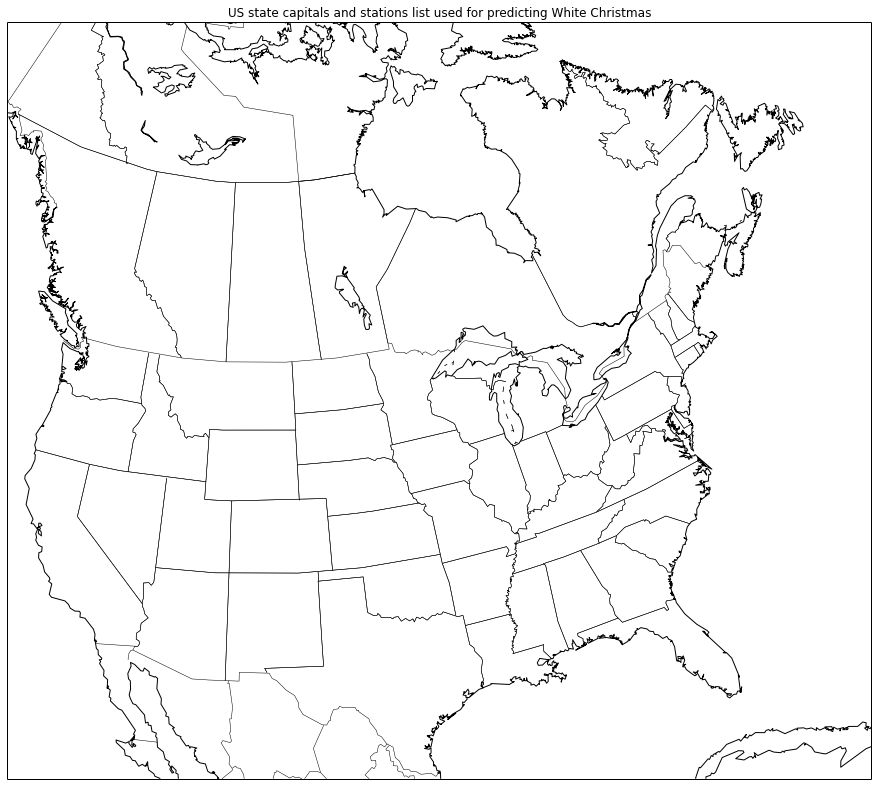

In [9]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt

# create the figure and axes instances.
fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

m = Basemap(llcrnrlon=-120.5,llcrnrlat=25.,urcrnrlon=-42.566,urcrnrlat=46.352,\
            rsphere=6371200.,\
            resolution='l',area_thresh=10000.,projection='stere',\
            lat_1=50.,lon_0=-107.,lat_0=90.,ax=ax)

m.drawcoastlines()
m.drawcountries()
m.drawstates()

for prob, lon, lat in stationsList:
    x,y = m(lon, lat)
    if prob == "c":
        color = 'ro'
        mSize = 20
    else:
        color = 'bo'
        mSize = 10
    m.plot(x, y, color, markersize=mSize)

ax.set_title('US state capitals and stations list used for predicting White Christmas')
plt.show()

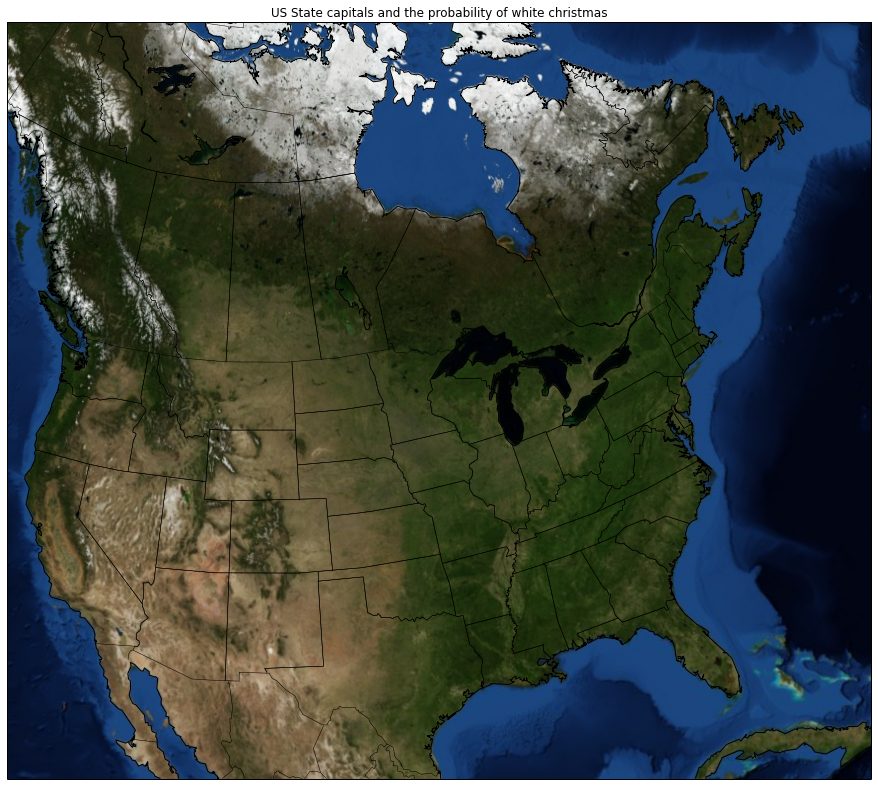

In [10]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
# create the figure and axes instances.
fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

m = Basemap(llcrnrlon=-120.5,llcrnrlat=25.,urcrnrlon=-42.566,urcrnrlat=46.352,\
            rsphere=6371200.,\
            resolution='l',area_thresh=10000.,projection='stere',\
            lat_1=50.,lon_0=-107.,lat_0=90.,ax=ax)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()

for city, lonlat in cityLongLatMap.iteritems():
    lon, lat = lonlat
    chance = (maxProbMap[city] * 35.0) + ((sumProbMap[city] / totalProbMap[city])*50.0) + ((p5ProbMap[city] / totalProbMap[city])*15)
#     maxProb = maxProbMap[city]
    x,y = m(lon, lat)
    tColor = 'k'
    if chance > 0:
        color = 'w*'
        mSize = 8 + (chance / 2)
    else:
        color = 'k*'
        tColor = 'w'
        mSize = 25
    m.plot(x, y, color, markersize=mSize)
    if city != "Honolulu":
        plt.text(x, y, int(chance), fontsize=10,fontweight='bold',color=tColor)

ax.set_title('US State capitals and the probability of white christmas')
plt.show()

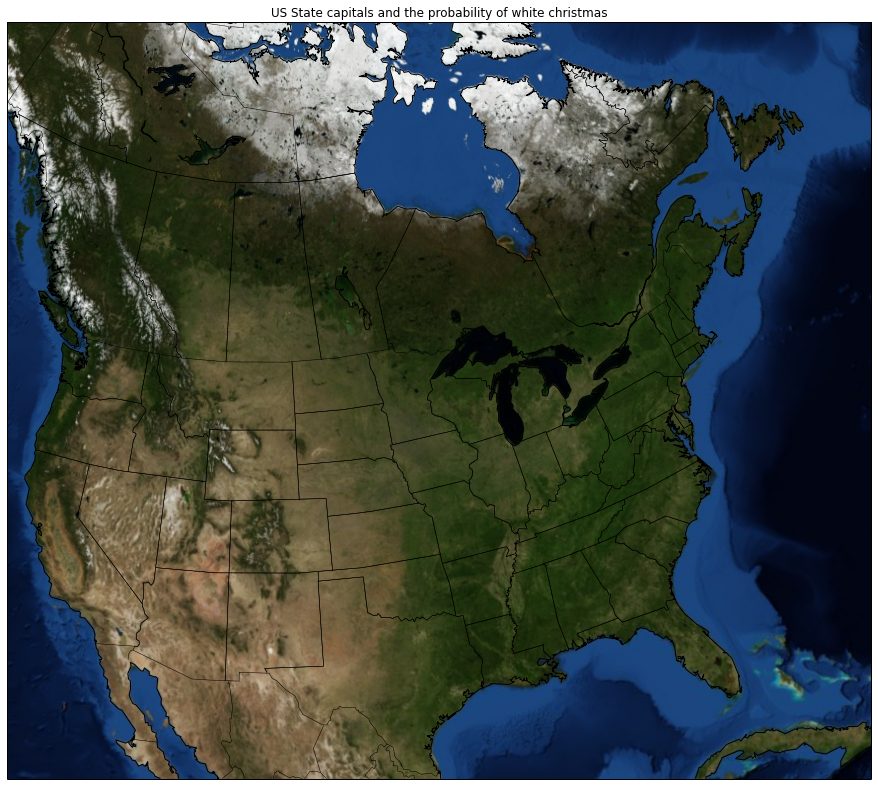

In [11]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
# create the figure and axes instances.
fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

m = Basemap(llcrnrlon=-120.5,llcrnrlat=25.,urcrnrlon=-42.566,urcrnrlat=46.352,\
            rsphere=6371200.,\
            resolution='l',area_thresh=10000.,projection='stere',\
            lat_1=50.,lon_0=-107.,lat_0=90.,ax=ax)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()

nov2015AvgTmpDict = populateNov2015TempAvg()
corrWeightage = 20.0
avgWeightage = 50.0

for city, lonlat in cityLongLatMap.iteritems():
    lon, lat = lonlat
    x = nov2015AvgTmpDict[city] * 10.0
    tmpCorrPrediction = (0.0002*pow(x,2) -0.0534*x + 3.65) / 10.0
    if tmpCorrPrediction > 1:
        tmpCorrPrediction = 1
    if (sumProbMap[city]*1.0 / totalProbMap[city]) <= 0.3:
        tmpCorrPrediction = sumProbMap[city]*1.0 / totalProbMap[city]
    if (sumProbMap[city]*1.0 / totalProbMap[city]) > 0.3 and (sumProbMap[city]*1.0 / totalProbMap[city]) <=0.6:
        avgWeightage = 40.0
        corrWeightage = 30.0
    if (sumProbMap[city]*1.0 / totalProbMap[city]) > 0.6:
        avgWeightage = 35.0
        corrWeightage = 35.0
    chance = (maxProbMap[city] * 25.0) + (tmpCorrPrediction*corrWeightage)+((sumProbMap[city]*1.0 / totalProbMap[city])*avgWeightage) + ((p5ProbMap[city]*1.0 / totalProbMap[city])*5.0)
                    
#     maxProb = maxProbMap[city]
    x,y = m(lon, lat)
    tColor = 'k'
    if chance > 0:
        color = 'w*'
        mSize = 8 + (chance / 2)
    else:
        color = 'k*'
        tColor = 'w'
        mSize = 25
    m.plot(x, y, color, markersize=mSize)
    if city != "Honolulu":
        plt.text(x, y, int(chance), fontsize=10,fontweight='bold',color=tColor)

ax.set_title('US State capitals and the probability of white christmas')
plt.show()

In [ ]:
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import numpy as np
import matplotlib.pyplot as plt
# create the figure and axes instances.
fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.8,0.8])

m = Basemap(llcrnrlon=-180.,llcrnrlat=-60,urcrnrlon=180.,urcrnrlat=80.,\
            rsphere=6371200.,\
            resolution='l',area_thresh=10000.,projection='stere',\
            lat_1=50.,lon_0=-107.,lat_0=90.,ax=ax)

m.drawcoastlines()
m.drawcountries()
m.drawstates()
m.bluemarble()

In [11]:
tempSnowList = []
actualTempSnowList = []

def tempCorrelation(startYear, endYear, startMonth, monthOffset, fun):
    sampleStations = getNearestStations()
    for oi, orow in sampleStations.iterrows():
        computeTmpSnowDAvgYears(orow["station"], startYear, endYear, startMonth, monthOffset, fun)
    print(len(tempSnowList))
#         tempCorrelationStation(orow["station"])

def computeTmpSnowDAvgYears(station, startYear, endYear, startMonth, monthOffset, fun):
    df = loadTable(station)
    for year in range(startYear, endYear+1):
        computeTmpSnowDAvgMonths(df, station, year, startMonth, monthOffset, fun)

def computeTmpSnowDAvgMonths(df, station, year, startMonth, monthOffset, fun):
    for month in range(startMonth, startMonth + monthOffset):
        month = month % 12
        if fun == "computeTmpSnowDAvg":
            computeTmpSnowDAvg(df, station, year, month)
        if fun == "computeWhiteTmpSnowDCorr":
            computeWhiteTmpSnowDCorr(df, station, year, month)
        if fun == "computeTmpSnowDAvgCloseInterval":
            computeTmpSnowDAvgCloseInterval(df, station, year, month)

def computeTmpSnowDAvg(df, station, year, month):
    
    # 1 inch = 25 mm
    df1 = df[(df['element'] == "TMIN") & (df['year'] == year) & (df['month'] == month)]
    df2 = df[(df['element'] == "SNWD") & (df['year'] == year) & (df['month'] == month)]
    df2 = df[(df['element'] == "SNWD") & (df['year'] == year) & (df['month'] == month)]
        
    if len(df1.index) == 1 and len(df2.index) == 1:
        
        for ti, trow in df1.iterrows():
            tempRow = trow
        for si, srow in df2.iterrows():
            snowDRow = srow
        tempSum = 0
        tempCount = 0
        
        sndCoverCount, sndDaysCount = 0,0
        for i in range(1,32):
            if tempRow[str(i)] != -9999:
                tempSum += (tempRow[str(i)] / 10.0)
                tempCount += 1
            if snowDRow[str(i)] != -9999:
                sndDaysCount += 1
                # 1 inch 25 mm
                if snowDRow[str(i)] >= 25:
                   sndCoverCount += 1
        if tempCount > 0 and  sndDaysCount > 0:
            tempSnowList.append((float(tempSum) / tempCount, sndCoverCount))
#             print("TempAvg : ",float(tempSum) / tempCount, " SnowCoverDays : ",sndDaysCount)

def computeTmpSnowDAvgCloseInterval(df, station, year, month):
    # 1 inch = 25 mm
    df1 = df[(df['element'] == "TMIN") & (df['year'] == year) & (df['month'] == month)]
    df2 = df[(df['element'] == "SNWD") & (df['year'] == year) & (df['month'] == 12)]
  
    if len(df1.index) == 1 and len(df2.index) == 1:
        
        for ti, trow in df1.iterrows():
            tempRow = trow
        for si, srow in df2.iterrows():
            snowDRow = srow
        tempSum = 0
        tempCount = 0
        
        sndCoverCount, sndDaysCount = 0,0
        for i in range(1,32):
            if tempRow[str(i)] != -9999:
                tempSum += (tempRow[str(i)] / 10.0)
                tempCount += 1
            if snowDRow[str(i)] != -9999:
                sndDaysCount += 1
                # 1 inch = 25 mm and i==25 means 25th of that month
                if snowDRow[str(i)] >= 25 and i==25 : #and i>=23 and i<=27:
                   sndCoverCount += 1
        if tempCount >= 25 and  sndDaysCount >= 25:
            x = float(tempSum) / tempCount * 10.0
            predicted = 0.0002*pow(x,2) -0.0534*x + 3.65
            tempSnowList.append((float(tempSum) / tempCount, sndCoverCount, predicted / 10.0))
            

def computeWhiteTmpSnowDCorr(df, station, year, month):
    
    # 1 inch = 25 mm
    df1 = df[(df['element'] == "TMIN") & (df['year'] == year) & (df['month'] == month)]
    df2 = df[(df['element'] == "SNWD") & (df['year'] == year) & (df['month'] == 12)]
    df3 = df[(df['element'] == "SNOW") & (df['year'] == year) & (df['month'] == 12)]
        
    if len(df1.index) == 1 and len(df2.index) == 1 and len(df3.index) == 1:
        
        for ti, trow in df1.iterrows():
            tempRow = trow
        for si, srow in df2.iterrows():
            snowDRow = srow
        for si, srow in df3.iterrows():
            snowRow = srow
        
        tempSum = 0
        tempCount = 0
        
             
        whiteChristmasDepth = max(-1, snowDRow['25'], snowRow['25'])
                                  
        for i in range(1,32):
            if tempRow[str(i)] != -9999:
                tempSum += (tempRow[str(i)] / 10.0)
                tempCount += 1
            
        if tempCount > 25 and  whiteChristmasDepth != -1:
            tempSnowList.append((float(tempSum) / tempCount, whiteChristmasDepth))
            
        

def writeTempSnowCorrData(fileName):
    tempSnowdDCorrelFrame = DataFrame(columns=("avgTemperature", "snowCoverCount"))

    rowIndex = 0
    for (temp, snwCoverCount) in tempSnowList:
        tempSnowdDCorrelFrame.loc[rowIndex] = [temp, snwCoverCount]
        rowIndex += 1
    
    tempSnowdDCorrelFrame.to_csv(rootPath + fileName, sep=',')
    
def writeTempSnowCorrDataWithPrediction(fileName):
    tempSnowdDCorrelFrame = DataFrame(columns=("avgTemperature", "snowCoverCount", "predicted"))

    rowIndex = 0
    for (temp, snwCoverCount, predicted) in tempSnowList:
        tempSnowdDCorrelFrame.loc[rowIndex] = [temp, snwCoverCount, predicted]
        rowIndex += 1
    
    tempSnowdDCorrelFrame.to_csv(rootPath + fileName, sep=',')

def readTempSnowCorrData(fileName):
    path = rootPath + fileName
    datatable = pd.read_table(path, sep=',', header=0)
    return datatable


In [ ]:
tempCorrelation(1990, 2013, 10, 6, "computeTmpSnowDAvg")  # Corr -0.62
writeTempSnowCorrData('temp_snowd_correl_input.csv') # Corr -0.62
tempSnowList = []

In [4]:
tempCorrelation(1990, 2013, 11, 2, "computeTmpSnowDAvg") # Corr -0.42
writeTempSnowCorrData('temp_snowd_correl_novdec_input.csv')
tempSnowList = []

4041


In [10]:
tempCorrelation(1990, 2013, 11, 1, "computeWhiteTmpSnowDCorr")
writeTempSnowCorrData('temp_snowd_correl_nov_white_input.csv') 
tempSnowList = []

3627


In [4]:
tempCorrelation(2008, 2013, 11, 1, "computeTmpSnowDAvgCloseInterval")
writeTempSnowCorrDataWithPrediction('temp_snowd_correl_nov_white_23_27_pred_ext.csv') 
tempSnowList = []

845


In [12]:
tempCorrelation(2008, 2013, 11, 1, "computeTmpSnowDAvgCloseInterval")
writeTempSnowCorrDataWithPrediction('temp_snowd_correl_nov_white_25_pred.csv') 
tempSnowList = []

845


In [26]:
import numpy as np

def evaluateModel(fileName, scale, ColHeaders):
    # Compute statistics
    
    path = rootPath + fileName
    statFrame = pd.read_table(path, sep=',', header=0)
    #statFrame.columns = ['Index','AvgTemp','Outcome','Prediction']
    statFrame.columns = ColHeaders
    
    print('Mean Squared Error: '+str((statFrame['Prediction']-statFrame['Outcome']).pow(2).mean()))
    print('Root Mean Squared Error: '+str(math.sqrt((statFrame['Prediction']-statFrame['Outcome']).pow(2).mean())))
    
    # Prediction column has fraction values. So only when a count >=1, it is considered as positive
    if scale == 1:
        statFrame.loc[statFrame['Prediction']< 0.3,'Prediction'] = 0
        statFrame.loc[statFrame['Prediction']>= 0.3,'Prediction'] = 1
        # Outcome column has integer values. So when a count > 0, it is considered as positive 
        # statFrame.loc[statFrame['Outcome']<= 0,'Outcome'] = 0
        # statFrame.loc[statFrame['Outcome']> 0,'Outcome'] = 1
    else:
        statFrame.loc[statFrame['Prediction']< 30,'Prediction'] = 0
        statFrame.loc[statFrame['Prediction']>= 30,'Prediction'] = 1
        statFrame.loc[statFrame['Outcome']< 30,'Outcome'] = 0
        statFrame.loc[statFrame['Outcome']>= 30,'Outcome'] = 1
    
    TP = ((statFrame['Prediction']==1) & (statFrame['Outcome']==1)).sum()
    TN = ((statFrame['Prediction']==0) & (statFrame['Outcome']==0)).sum()
    FP = ((statFrame['Prediction']==1) & (statFrame['Outcome']==0)).sum()
    FN = ((statFrame['Prediction']==0) & (statFrame['Outcome']==1)).sum()
    print('True Positive: '+str(TP))
    print('True Negative: '+str(TN))
    print('False Positive: '+str(FP))
    print('False Negative: '+str(FN))
    #print '       Pred Yes \t Pred No'
    #print 'Act Yes {:4d}      {:4d}'.format(TP,FN)
    #print 'Act No  {:4d}      {:4d}'.format(FP,TN)
    precision = float(TP)/(TP+FP)
    recall = float(TP)/(TP+FN)
    print('Precision: '+str(precision))
    print('Recall: '+str(recall))
    print('F-score: '+str(2*precision*recall/(precision+recall)))

In [17]:
evaluateModel('temp_snowd_correl_nov_white_25_pred.csv', 1, ['Index','AvgTemp','Outcome','Prediction'])

Mean Squared Error: 0.19156715476
Root Mean Squared Error: 0.437683852524
True Positive: 276
True Negative: 301
False Positive: 215
False Negative: 53
Precision: 0.562118126273
Recall: 0.838905775076
F-score: 0.673170731707


In [27]:

evaluateModel('baseline_ext_eval_input.csv', 100, ['Index','c1','c2','c3','c4','c5','Prediction','Outcome'])


Mean Squared Error: 907.195134143
Root Mean Squared Error: 30.11968018
True Positive: 159
True Negative: 409
False Positive: 71
False Negative: 87
Precision: 0.691304347826
Recall: 0.646341463415
F-score: 0.668067226891


In [28]:
evaluateModel('baseline_ext_w_tmpcorr_eval_input.csv', 100, ['Index','c1','c2','c3','c4','c5','c6','Prediction','Outcome'])

Mean Squared Error: 898.570432707
Root Mean Squared Error: 29.9761644095
True Positive: 176
True Negative: 393
False Positive: 87
False Negative: 70
Precision: 0.669201520913
Recall: 0.715447154472
F-score: 0.691552062868


In [29]:
evaluateModel('baseline_ext_w_tmpcorr_eval_35_65.csv', 100, ['Index','c1','c2','c3','c4','c5','c6','Prediction','Outcome'])

Mean Squared Error: 915.680608787
Root Mean Squared Error: 30.2602149494
True Positive: 181
True Negative: 376
False Positive: 104
False Negative: 65
Precision: 0.635087719298
Recall: 0.735772357724
F-score: 0.681732580038


In [8]:
import statsmodels.formula.api as smf

def findRegression(fileName, xLabel, yLabel, isWhite):


    
    dFrame = readTempSnowCorrData(fileName)
    print("Correlation : ",dFrame[['avgTemperature','snowCoverCount']].corr())
    
    tempSnowSumMap = {}
    tempSnowCountMap = {}
    tmpFrame = DataFrame(columns=('avgTemperature', 'snowCoverCount'))
    
    for oi, orow in dFrame.iterrows():
        key = int(orow['avgTemperature'] * 10)
        if key in tempSnowSumMap:
            tempSnowSumMap[key] = tempSnowSumMap[key] + orow['snowCoverCount']
            tempSnowCountMap[key] = tempSnowCountMap[key] + 1
        else:
            tempSnowSumMap[key] = orow['snowCoverCount']
            tempSnowCountMap[key] = 1
    
    rowIndex = 0        
    for key in tempSnowSumMap:
        if isWhite:
            # taking average of depth
            tmpFrame.loc[rowIndex] = [key, int(tempSnowSumMap[key]/tempSnowCountMap[key])]
        else:
            # taking average of count
            tmpFrame.loc[rowIndex] = [key, int(tempSnowSumMap[key]/tempSnowCountMap[key]*10.0)]
        rowIndex += 1
    
    # tmpFrame = tmpFrame.head(10)
#     print(tmpFrame)
    
        
#     isLog = False
    
#     if isLog:

#         tmpFrame['snowCoverCount'] = np.log1p(tmpFrame['snowCoverCount'])
#         tmpFrame = tmpFrame[tmpFrame['avgTemperature'] < 50]
    # plot lstat (% lower status of the population) against median value
    plt.figure(figsize=(6 * 1.618, 6))
    plt.scatter(tmpFrame['avgTemperature'], tmpFrame['snowCoverCount'], s=10, alpha=0.3)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    
    # points linearlyd space on lstats
    x = pd.DataFrame({'avgTemperature': np.linspace(tmpFrame.avgTemperature.min(), tmpFrame.avgTemperature.max(), 100)})
    
    # 1-st order polynomial
    poly_1 = smf.ols(formula='snowCoverCount ~ 1 + avgTemperature', data=tmpFrame).fit()
    plt.plot(x.avgTemperature, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared, 
             alpha=0.9)
    
    # 2-nd order polynomial
    poly_2 = smf.ols(formula='snowCoverCount ~ 1 + avgTemperature + I(avgTemperature ** 2.0)', data=tmpFrame).fit()
    plt.plot(x.avgTemperature, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, 
             alpha=0.9)
    
    # 3-rd order polynomial
    poly_3 = smf.ols(formula='snowCoverCount ~ 1 + avgTemperature + I(avgTemperature ** 2.0) + I(avgTemperature ** 3.0)', data=tmpFrame).fit()
    plt.plot(x.avgTemperature, poly_3.predict(x), 'r-', alpha=0.9,
             label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)
    
    plt.legend()
    
    print(poly_1.summary())
    print('\n')
    print(poly_2.summary())
    print('\n')
    print(poly_3.summary())

Correlation :                  avgTemperature  snowCoverCount
avgTemperature        1.000000       -0.622744
snowCoverCount       -0.622744        1.000000
                            OLS Regression Results                            
Dep. Variable:         snowCoverCount   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     1406.
Date:                Thu, 13 Nov 2014   Prob (F-statistic):          3.83e-141
Time:                        05:39:27   Log-Likelihood:                -2421.5
No. Observations:                 456   AIC:                             4847.
Df Residuals:                     454   BIC:                             4855.
Df Model:                           1                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------

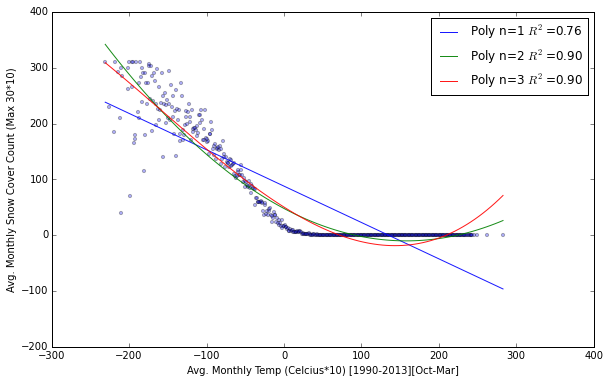

In [55]:
findRegression('temp_snowd_correl_input.csv', 'Avg. Monthly Temp (Celcius*10) [1990-2013][Oct-Mar]', 'Avg. Monthly Snow Cover Count (Max 30*10)', False )

Correlation :                  avgTemperature  snowCoverCount
avgTemperature        1.000000       -0.278712
snowCoverCount       -0.278712        1.000000
                            OLS Regression Results                            
Dep. Variable:         snowCoverCount   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     91.03
Date:                Thu, 13 Nov 2014   Prob (F-statistic):           6.32e-19
Time:                        05:32:46   Log-Likelihood:                -1787.2
No. Observations:                 290   AIC:                             3578.
Df Residuals:                     288   BIC:                             3586.
Df Model:                           1                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------

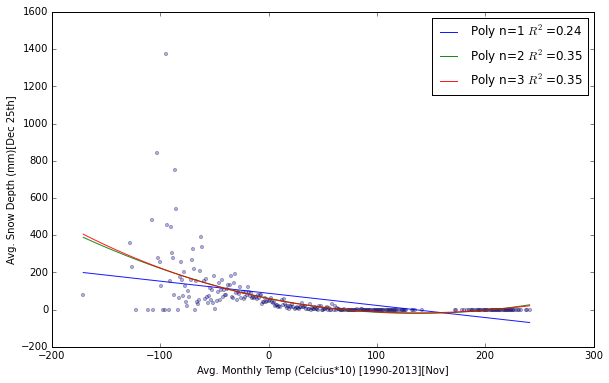

In [52]:
findRegression('temp_snowd_correl_nov_white_input.csv', 'Avg. Monthly Temp (Celcius*10) [1990-2013][Nov]', 'Avg. Snow Depth (mm)[Dec 25th] ', True )

Correlation :                  avgTemperature  snowCoverCount
avgTemperature        1.000000       -0.481603
snowCoverCount       -0.481603        1.000000
                            OLS Regression Results                            
Dep. Variable:         snowCoverCount   R-squared:                       0.580
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     272.5
Date:                Mon, 01 Dec 2014   Prob (F-statistic):           5.29e-39
Time:                        20:35:12   Log-Likelihood:                -755.40
No. Observations:                 199   AIC:                             1515.
Df Residuals:                     197   BIC:                             1521.
Df Model:                           1                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------

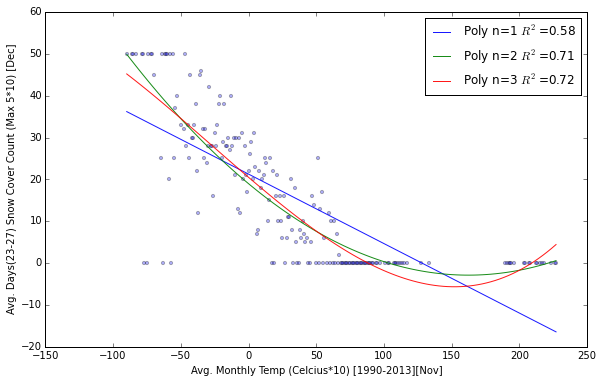

In [11]:
findRegression('temp_snowd_correl_nov_white_23_27_pred.csv', 'Avg. Monthly Temp (Celcius*10) [1990-2013][Nov]', 'Avg. Days(23-27) Snow Cover Count (Max 5*10) [Dec]', False)

Correlation :                  avgTemperature  snowCoverCount
avgTemperature        1.000000       -0.423198
snowCoverCount       -0.423198        1.000000
                            OLS Regression Results                            
Dep. Variable:         snowCoverCount   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     238.4
Date:                Wed, 03 Dec 2014   Prob (F-statistic):           9.04e-36
Time:                        19:11:44   Log-Likelihood:                -443.30
No. Observations:                 199   AIC:                             890.6
Df Residuals:                     197   BIC:                             897.2
Df Model:                           1                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------

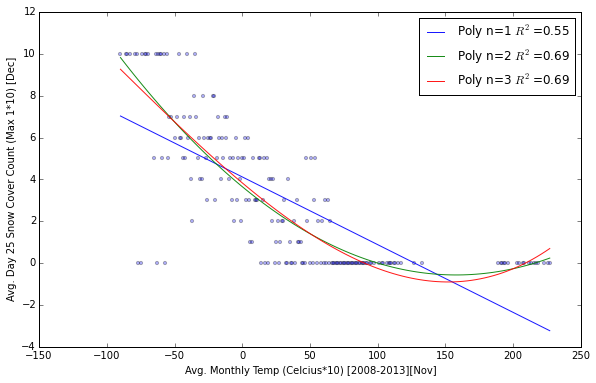

In [9]:
findRegression('temp_snowd_correl_nov_white_25_pred.csv', 'Avg. Monthly Temp (Celcius*10) [2008-2013][Nov]', 'Avg. Day 25 Snow Cover Count (Max 1*10) [Dec]', False)